In [6]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [7]:
# Load the time series dataset
data = pd.read_csv('../datasets/complete_data/df.csv')

# Change column names to match naming convention
data = data.rename(columns={'start MTU (UTC)': 'ds', 'Day-ahead Price [EUR/MWh] BZN|NO1': 'y'})

# Split the dataset into training and testing sets
# Split the data into training and testing sets
X = data.drop(['y', 'ds'], axis=1)
y = data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.head()

,Day-ahead Price [EUR/MWh] BZN|NO3,Day-ahead Price [EUR/MWh] BZN|NO5,Day-ahead Price [EUR/MWh] BZN|SE3,Actual Total Load [MW] - BZN|NO5,Actual Total Load [MW] - BZN|SE3,Hydro Run-of-river and poundage - BZN|NO1,Hydro Water Reservoir - BZN|NO1,Wind Onshore - BZN|NO1,Hydro Pumped Storage Aggregated- BZN|NO2,Hydro Run-of-river and poundage - BZN|NO2,...,CBF BZN|NO2 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO2 [MW],CBF BZN|NO3 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO3 [MW],CBF BZN|NO5 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO5 [MW],CBF BZN|SE3 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|SE3 [MW],Stored Energy Value Water Reservoirs and Hydro Storage Plants [MWh] - BZN|NO5,Stored Energy Value Water Reservoirs and Hydro Storage Plants [MWh] - BZN|SE3
2031,15.50,184.26000,15.50,1888.0,9704.0,857.0,427.0,52.0,329.0,620.000000,...,504.0,0.0,457.000,0.0,411.0,0.0,875.0,0.0,3235284.0,885000.0
6570,67.74,186.04000,67.74,1710.0,8014.0,1584.0,433.0,190.0,0.0,633.781250,...,0.0,979.0,294.000,0.0,0.0,179.0,1806.0,0.0,12605383.0,1517000.0
6371,73.07,330.11000,295.30,1643.0,8880.0,910.0,173.0,198.0,1.0,350.714286,...,224.0,0.0,514.000,0.0,486.0,0.0,767.0,0.0,12231292.0,1478000.0
3490,5.63,80.06875,5.63,1692.0,8410.0,1416.0,142.0,37.0,1.0,484.000000,...,88.0,0.0,358.125,0.0,359.0,0.0,887.0,0.0,3405141.0,1503000.0
7700,35.94,37.63000,37.63,2046.0,11003.0,1721.0,845.0,129.0,0.0,790.234783,...,0.0,279.0,354.000,0.0,1499.0,0.0,530.0,0.0,15137592.0,1853000.0


In [8]:
# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the training set
model.fit(X_train, y_train)

LinearRegression()

In [9]:
# Make a prediction on the testing set
predicted_values = model.predict(X_test)

# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_test, predicted_values)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_test, predicted_values)
print("Mean absolute percentage error: ", mape)

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_test, predicted_values)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Rood mean squared error:        ", rmse)


Mean absolute error:             1.7897082783243206
Mean absolute percentage error:  0.024023283243505427
Mean squared error:              24.666357159335575
Rood mean squared error:         4.966523649328127


In [10]:
# Get the absolute values of the coefficients
coefficients = np.abs(model.coef_)

# Create a dictionary of feature names and importance scores
feature_importance = dict(zip(X.columns, coefficients))

# Print the feature importance in descending order
for feature, importance in sorted(feature_importance.items(), key=lambda x: x[1], reverse=True):
    print("{}: {:.2f}%".format(feature, importance*100))

Day-ahead Price [EUR/MWh] BZN|NO5: 98.94%
Waste - BZN|NO2: 19.67%
Waste - BZN|NO3: 5.88%
Fossil Gas - BZN|NO5: 5.41%
CBF BZN|NO1 > BZN|NO3 [MW]: 2.52%
Other renewable - BZN|NO3: 1.65%
Day-ahead Price [EUR/MWh] BZN|SE3: 1.36%
Hydro Pumped Storage Aggregated- BZN|NO3: 1.24%
Waste - BZN|NO5: 0.96%
Hydro Pumped Storage Aggregated- BZN|NO2: 0.78%
Hydro Run-of-river and poundage - BZN|NO5: 0.68%
Hydro Run-of-river and poundage - BZN|NO3: 0.57%
Solar - BZN|SE3: 0.36%
Wind Onshore - BZN|NO1: 0.36%
Day-ahead Price [EUR/MWh] BZN|NO3: 0.35%
Actual Total Load [MW] - BZN|NO5: 0.26%
Other - BZN|SE3: 0.26%
CBF BZN|NO5 > BZN|NO1 [MW]: 0.17%
CBF BZN|NO1 > BZN|NO2 [MW]: 0.17%
Hydro Run-of-river and poundage - BZN|NO1: 0.16%
CBF BZN|NO1 > BZN|NO5 [MW]: 0.15%
CBF BZN|SE3 > BZN|NO1 [MW]: 0.12%
CBF BZN|NO2 > BZN|NO1 [MW]: 0.09%
CBF BZN|NO1 > BZN|SE3 [MW]: 0.08%
Wind Onshore - BZN|NO2: 0.08%
Hydro Pumped Storage Aggregated- BZN|NO5: 0.07%
Wind Onshore - BZN|NO3: 0.07%
Hydro Water Reservoir - BZN|NO1: 0.06%
H

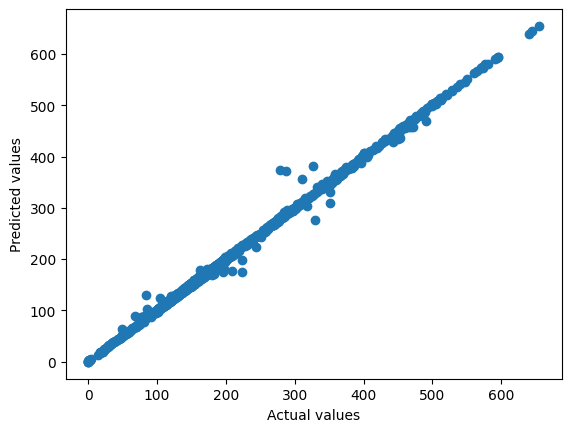

In [11]:
# Plot the predicted values against the actual values
plt.plot(y_test, predicted_values, 'o')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()